<h3>2. LSTM på alla paragrafer, plocka utan hidden -> fully connected.</h3>

<p>Denna modellen är mer avancerad då den inte enbart tar ett medelvärde av de embeddings SentenceTransformer ger utan matar in dem i ett LSTM-lager.</p>

In [1]:
from sentence_transformers import SentenceTransformer, models
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

<p>Data över uttalanden:</p>

In [156]:
speeches = []
parties = []
ids = []
all_sentences = []
all_paragraphs = []

possible_parties = ["S","M","SD","V","MP","C","KD","L"]

# The directory where data is located
data_dirs = ["speech_data/19_20/","speech_data/20_21/","speech_data/21_22/","speech_data/18_19/"]
year_indices = [0,0,0,0]
data = []
i = 0
for year, data_dir in enumerate(data_dirs):
    year_indices[year] = len(speeches)
    for file in os.listdir(data_dir):
        if file.endswith(".json"):
            with open(data_dir+file,"r") as f:
                data = json.load(f)
                speech = data["anforande"]["anforandetext"]
                party = data["anforande"]["parti"]
                id = data["anforande"]["dok_id"]+"-"+data["anforande"]["anforande_nummer"]
                # If it is a party who has spoken,
                if party in possible_parties:
                    soup = BeautifulSoup(speech, 'html.parser')
                    paragraphs = []
                    for paragraph in soup.find_all("p"):
                        text = paragraph.get_text()
                        if text != "":
                            
                            """sentences = []
                            for s in re.split("\. |\! |\? ",text):
                                if s != "":
                                    sentences.append(s)
                                    all_sentences.append(s)
                            if sentences != []:
                                all_paragraphs.append(text)"""
                            all_paragraphs.append(text)
                            paragraphs.append(text)
                    if paragraphs != []:
                        parties.append(party)
                        speeches.append(paragraphs)
                        ids.append(id)

print(year_indices)
assert len(parties) == len(speeches)

[0, 10321, 25330, 37398]


In [4]:
print(len(speeches))

46686


<p>Skapa embedding-modellen.</p>

In [5]:
model_name = "paraphrase-multilingual-mpnet-base-v2"
embedding_model = SentenceTransformer(model_name)

<p>Gör embeddings av paragraferna.</p>

In [4]:
#paragraph_embeddings = embedding_model.encode(paragraphs,show_progress_bar=True) #Kanske ändra maxlängd?
#torch.save(paragraph_embeddings, f="multilingual_22-23_ca50k_new.pt")

<p>Skapa datasetklassen</p>

In [200]:
# This Dataset is supposed to return a speech divided into paragraphs as well as the party.

class ParagraphDataset(Dataset):
    def __init__(self,speeches,parties,ids,start_index,stop_index,embedding_model=None,file_name=""):
        assert len(speeches) == len(parties)
        self.length = stop_index-start_index
        self.party_order = ["S","M","SD","V","MP","C","KD","L"]
        self.party_indices = {}
        self.embeddings_file_name = file_name
        for i, p in enumerate(self.party_order):
            self.party_indices[p] = i
        print(self.party_indices)
        self.party_letters = parties[start_index:stop_index]
        self.party_numbers = torch.Tensor([self.party_indices.get(p) for p in self.party_letters]).long()
        self.ids = ids[start_index:stop_index]
        no_paragraphs = 0
        paragraph_list = []
        count = 0
        for sp in speeches[start_index:stop_index]:
            count += 1
            for pa in sp:
                paragraph_list.append(pa)
                no_paragraphs += 1
        print(count)
        print("The amount of paragraphs are", str(len(paragraph_list)))
        if embedding_model!=None:
            print("Encoding sentences...")
            paragraph_embeddings = embedding_model.encode(paragraph_list,show_progress_bar=True)
            # Save the data to load later
            torch.save(paragraph_embeddings,f=self.embeddings_file_name)
        else:
            print("Loading embeddings from file...")
            paragraph_embeddings = torch.load(self.embeddings_file_name)
        self.speeches = []
        self.speech_texts = []
        index = 0
        for i_s, sp in enumerate(speeches[start_index:stop_index]):
            self.speeches.append([])
            self.speech_texts.append(sp)
            for i_p, pa in enumerate(sp):
                self.speeches[-1].append(paragraph_embeddings[index])
                index += 1
        assert index == no_paragraphs
        print("Number of paragraphs: ",str(index))
        print("Number of parties: ",str(len(self.party_numbers)))
        print("Number of speeches: ",str(len(self.speeches)))
        print("Number of IDs: ",str(len(self.ids)))


    def dump(self,filename):
        with open(filename, "w", encoding='utf8') as f:
            for i in range(self.length):
                data = {"party":self.party_letters[i],"party number":int(self.party_numbers[i]),"speech":self.speech_texts[i],"ID":self.ids[i]}
                #data["speech embeddings"] = 
                json.dump(data, f,indent=2)

    def dump_embeddings_and_sentences(self,filename):
        with open(filename, "w", encoding='utf8') as f:
            for i in range(self.length):
                embedding = self.speeches[i]
                data = {str(embedding):str(self.speech_texts[i])}
                #data["speech embeddings"] = 
                json.dump(data, f,indent=2)


    def get_item_verbose(self, index):
        return self.speech_texts[index],self.speeches[index],self.party_letters[index],self.party_numbers[index],self.ids[index]

    def __len__(self):
        return self.length
    
    # Get speech at a certain index
    def __getitem__(self, index):
        # The index list decides which paragraphs to use
        speech = self.speeches[index]
        #print(speech[0].shape,speech[1].shape)
        party = self.party_numbers[index]
        return torch.Tensor(speech), torch.Tensor(party)

In [13]:
def collate_fn(data):
    #print("Before padding (first in embedding):")
    #print([d[0][:,0] for d in data])
    input = torch.nn.utils.rnn.pad_sequence([torch.flip(d[0],[0]) for d in data], batch_first=True)
    input = torch.flip(input,[1])
    #print("After padding: ")
    #print(input[:,:,0])
    output = torch.tensor(np.array([d[1] for d in data]))
    return input, output

In [8]:
# Use the first three years as training data and split the last year into val and test data
train_stop = year_indices[3]
val_stop = (year_indices[3]+len(speeches))//2
test_stop = len(speeches)
print(train_stop,val_stop,test_stop)

37398 42042 46686


In [201]:
train_set = ParagraphDataset(speeches,parties,ids,0,train_stop,embedding_model=None,file_name="train_embeddings.pt")
val_test_set = ParagraphDataset(speeches,parties,ids,train_stop,test_stop,embedding_model=None,file_name="val_test_embeddings.pt")

{'S': 0, 'M': 1, 'SD': 2, 'V': 3, 'MP': 4, 'C': 5, 'KD': 6, 'L': 7}
37398
The amount of paragraphs are 276626
Loading embeddings from file...
Number of paragraphs:  276626
Number of parties:  37398
Number of speeches:  37398
Number of IDs:  37398
{'S': 0, 'M': 1, 'SD': 2, 'V': 3, 'MP': 4, 'C': 5, 'KD': 6, 'L': 7}
9288
The amount of paragraphs are 65032
Loading embeddings from file...
Number of paragraphs:  65032
Number of parties:  9288
Number of speeches:  9288
Number of IDs:  9288


In [188]:
val_set, test_set = torch.utils.data.random_split(val_test_set,[val_test_set.length//2,val_test_set.length-val_test_set.length//2])

In [204]:
def assert_correct_labeling(dataset, random_samples):
    # If ID starts with 6, its from 18_19, with 7 19_20 and so on.
    ID_to_dir = {"H6":"speech_data/18_19/","H7":"speech_data/19_20/","H8":"speech_data/20_21/","H9":"speech_data/21_22/"}
    for i in range(random_samples):
        index = int(np.random.rand()*len(dataset))
        speech_text, speech_embedding, party_text, party_number, ID = dataset.get_item_verbose(index)
        ID_start = ID[:2]
        dir = ID_to_dir[ID_start]
        with open(dir+ID+".json","r") as f:
            data = json.load(f)
            speech = data["anforande"]["anforandetext"]
            party = data["anforande"]["parti"]
            id = data["anforande"]["dok_id"]
            # Make sure that it is the right party
            try:
                assert party == party_text
            except AssertionError:
                print("Expected ", party," got ",party_text)
            # Make sure that it is the right speech
            print(speech_text)
            print(speech)

In [202]:
train_set.dump_embeddings_and_sentences(filename="embeddings_to_paragraphs.jsonl")

KeyboardInterrupt: 

In [238]:
assert_correct_labeling(val_test_set,10)

['Fru talman! Tack, Morgan Johansson, för att du medverkar i debatten om den proposition som regeringen lagt fram! Jag noterade i ditt anförande att du nämner en rad olika åtgärder som är viktiga för att skapa trygghet i många bostadsområden. Sverigedemokraterna har bland annat på det bostadspolitiska området lagt fram områdesplanering som en viktig insats för att skapa polisära insatser som gör det tryggare i de utsatta områdena. Där finns det mycket att göra.', 'När det gäller straffskalorna för skärpta straff för olaglig handel med hyreskontrakt förordar Sverigedemokraterna att man ska ha en högre straffsats. Den grovt kriminella sektorn handhar på ett mer systematiskt sätt hyreskontrakten. Den brottsligheten är i proportion till grovt bedrägeri och grovt skattebrott, anser Sverigedemokraterna. Därför anser vi att man ska ha som högstanivå sex års fängelse i stället för fyra år, som är regeringens förslag.', 'Det är också ett bra sätt att kunna verka aktivt med flera åtgärder mot de

In [19]:
train_set.dump("train_data.jsonl")
val_test_set.dump("val_test_data.jsonl")

# Compare to the correct data
t = 10
for year, data_dir in enumerate(data_dirs):
    year_indices[year] = len(speeches)
    print("Year"+str(year))
    i = 0
    for file in os.listdir(data_dir):
        if file.endswith(".json"):
            with open(data_dir+file,"r") as f:
                data = json.load(f)
                print(data["anforande"]["parti"])
                print(data["anforande"]["anforandetext"])
                i += 1
        if i == t: 
            break

Year0
MP
<p>Fru talman! Ann-Christine From Utterstedt gör sig nu skyldig till att blanda siffror och tider. Den siffran stämmer inte. Vi har inte den typen av överdödlighet i det här läget. Tvärtom ser vi nu att smittspridningen minskar och att antalet som vårdas i vanlig sjukvård och intensivvård minskar. Det gör att vi nu kan ta ytterligare steg framåt och börja med testning i stor skala, vilket regeringen nu har aviserat att vi kommer att se till att det finns resurser för. Vi kommer också att tillsätta en kommission som ska utvärdera pandemin och de åtgärder som vidtagits. Den kommer att ge resultat framöver.</p>
M
<p>Fru talman! Tack, Lena Micko, för svaret! Jag måste dock börja med att ifrågasätta påståendet i ministerns svar att nyanlända etablerar sig i en snabbare takt på arbetsmarknaden. Det är faktiskt vilseledande att påstå detta.</p><p>Enligt en rapport jag själv har begärt från riksdagens utredningstjänst är det efter två år i etableringsreformen bara 6 procent av de nyan

<p>Skapa klassificeringsmodellen:</p>

In [226]:
class SpeechClassifier(nn.Module):
    """def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_size = batch_size

    def forward(self,x):
        #x = torch.flip(x,[1])
        #x = x/torch.linalg.vector_norm(x,ord=2,dim=1)
        f, (h,c) = self.lstm(x)
        h = self.dropout(h)
        output = self.fc(h)
        return output.squeeze()"""

    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Used to be: bidirectional, 2-layer, dropout=0.3 between them
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(4*hidden_size, output_size)
        self.batch_size = batch_size

    def forward(self,x):
        #print("X shape: "+str(x.shape))
        #print("Norm shape: "+str(torch.linalg.vector_norm(x,ord=2,dim=1).shape))
        #x = torch.div(x,torch.linalg.vector_norm(x,ord=2,dim=1).unsqueeze(1))
        f, (h,c) = self.lstm(x)
        #print("h: ",str(h.shape))
        #print("The rows of the hidden state for the first item: ")
        #for i in range(4):
        #    print("Row",str(i),str(h[i,0,:]))
        batch_size = h.shape[1]
        h = torch.permute(h,(1,0,2))
        h = torch.reshape(h,(batch_size,self.hidden_size*4))
        #print("Once h is permuted to shape ",str(h.shape),", it is the following for the first item")
        #print(str(h[0,:]))
        #print(str(h.shape))
        h = self.dropout(h)
        output = self.fc(h)
        return output.squeeze()


<p>Initialize the model:</p>

In [227]:
batch_size = 256
speech_classifier = SpeechClassifier(768, 64, 8, batch_size)

In [233]:
# load a trained version
speech_classifier.load_state_dict(torch.load("model_2_bidirectional_LSTM.pth"))

<All keys matched successfully>

<p>Now train the classifier:</p>

In [217]:
def prepare_data_loaders(train,val,test,collate_fn,batch_size,train_size=1):
    # Train and evaluate on only a proportion of the set
    if train_size < 1:
        train_set, _ = torch.utils.data.random_split(train,[train_size,1-train_size])
    else:
        train_set = train
    val_set = val

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=1024, shuffle=True, collate_fn=collate_fn)
    return train_loader, val_loader, test_loader

In [218]:
def train_model(model, optimizer, epochs, train_loader, val_loader,  loss_fn,max_lr=1e-3, save=True, plot=True):
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)
    
    train_length = len(train_loader)
    print("Train length"+str(train_length))
    val_length = len(val_loader)
    print("Val length"+str(val_length))

    train_losses = []
    learning_rates = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        # Train
        model.train()
        for i, (X_train, y_train) in enumerate(train_loader):
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            learning_rates.append(scheduler.get_last_lr()[0])
            train_losses.append(loss.item())

        # Evaluate
        model.eval()
        for i, (X_val, y_val) in enumerate(val_loader):
            y_pred = model(X_val)
            loss = loss_fn(y_pred, y_val)
            val_losses.append(loss.item())
        
        clear_output()
        print("Train loss: "+str(sum(train_losses[-train_length:])/(train_length)))
        print("Validation loss: "+str(sum(val_losses[-(val_length):])/((val_length))))
        print("Learning rate: "+str(learning_rates[-1]))
    
    if save:
        # Save and plot losses
        torch.save(train_losses,f="train_losses_model_2.pt")
        torch.save(val_losses,f="val_losses_model_2.pt")
    if plot:
        t1 = np.arange(len(train_losses))
        t2 = train_length/val_length*np.arange(len(val_losses))
        plt.scatter(t1,train_losses,s=0.2)
        plt.scatter(t2,val_losses,s=0.2)
        plt.show()

In [230]:
# Important parameters
train_proportion = 1
epochs = 5
optimizer = torch.optim.Adam(speech_classifier.parameters())
loss_fn = nn.CrossEntropyLoss()

In [220]:
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_set,val_set,test_set,collate_fn,batch_size,train_size=train_proportion)

100%|██████████| 5/5 [06:52<00:00, 82.48s/it]

Train loss: 0.7316118754497191
Validation loss: 1.3646408758665387
Learning rate: 1.3321073001068384e-08


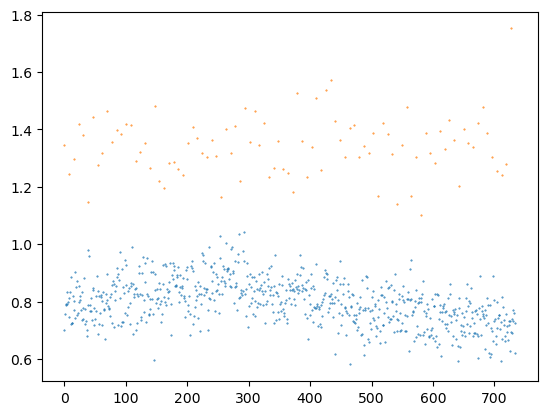

In [231]:
# Train the model
train_model(speech_classifier,optimizer,epochs,train_loader,val_loader,loss_fn)

In [243]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model,test_loader):
    model.eval()
    y_tests = np.array([])
    y_preds = np.array([])
    for i, (X_test, y_test) in enumerate(test_loader):
        y_pred = model(X_test).softmax(dim=1).argmax(dim=1)
        y_tests = np.concatenate((y_tests,y_test))
        y_preds = np.concatenate((y_preds,y_pred))

    print(classification_report(y_tests,y_preds,target_names=possible_parties))
    cm = confusion_matrix(y_tests, y_preds)
    ConfusionMatrixDisplay(cm,display_labels=possible_parties).plot()

<p>Evaluate.</p>

              precision    recall  f1-score   support

           S       0.63      0.77      0.70      1416
           M       0.52      0.53      0.53       819
          SD       0.47      0.45      0.46       516
           V       0.56      0.53      0.54       478
          MP       0.43      0.42      0.42       401
           C       0.51      0.38      0.43       338
          KD       0.53      0.41      0.46       390
           L       0.57      0.40      0.47       286

    accuracy                           0.56      4644
   macro avg       0.53      0.49      0.50      4644
weighted avg       0.55      0.56      0.55      4644



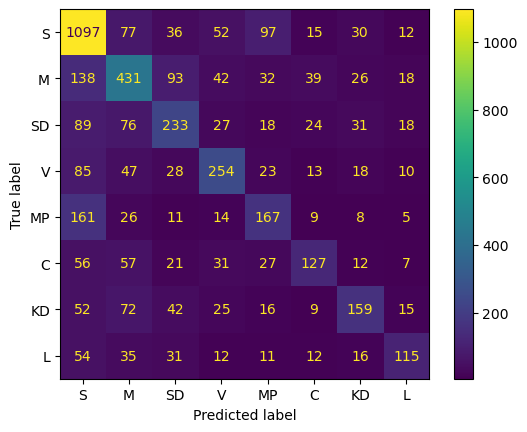

In [244]:
evaluate_model(speech_classifier,test_loader)

In [30]:
torch.save(speech_classifier.state_dict(), "model_2_bidirectional_LSTM.pth")